# EE 467 Lab 5: Detecting Credit Card Fraud with Decision Tree

In lab 5 and lab 6, we will go through a famous machine learning contest on Kaggle-**detecting fraud credit card transactions**, and learn about **decision tree, random forest and ensemble learning algorithms** in the meantime. Today, our task is to analyze and pre-process the credit card transactions dataset to resolve its inherent issues. We will then train a decision tree classifier on the transform features to identify fraud credit card transactions.

## Task Description
### Background

Fraudulent credit card transactions create major losses for both cardholders and financial institutions. According to the Nilson Report, worldwide payment card fraud losses were \$33.83B in 2023 and \$33.41B in 2024.

### Challenges in Detection

1. Uncommon: Fraud transactions are rare compared to normal transactions, hence there are few samples where we can learn from to identify these transactions. We will see in the later part of this lab that less than 0.2% of the transactions are in the fraud class.
2. Concealed: Fraudsters will try their best to blend in and conceal their activities.
3. Change over time: Patterns of fraud transactions change over time so that fraudsters could avoid getting caught.

### Evaluate Machine Learning-based Fraud Detection

Traditionally, rules-based expert systems are deployed to catch fraud transactions. While they could do an excellent jon to uncover existing fraud patterns, they are not effective for new and covert fraud schemes. Recently, financial institutions start to apply machine learning algorithms to credit card fraud identification because of their flexibility and adaptation to new fraud patterns. However, when compared to regular machine learning tasks, there are a few extra requirements for evaluation of the fraud transaction classifier:

* Instead of looking at the overall accuracy, we are more interested in the precision and recall, as the credit card transactions dataset is highly unbalanced. A deterministic classifier that always marks transactions as non-fraud could achieve over 99.8% of overall accuracy, but such a classifier is meaningless in terms of identifying fraud because its precision and recall in the fraud class are both zero.
* Besides, we also want to reduce false positives because in that case normal transactions are also blocked, which can be annoying for benign credit card users.

## Lab Dependencies

Apart from `numpy`, `pandas`, `scikit-learn` (`sklearn`) and `matplotlib`, we need to install two more external libraries for this lab: `seaborn` and `imbalanced-learn` (`imblearn`).

In [1]:
%pip install numpy pandas scikit-learn matplotlib seaborn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
!tar -xJf credit-card.tar.xz #<--- Use this to unzip the dataset folder in Colab

## Feature Analysis

Before building machine learning classification models, we need to know more about the characteristics of the credit card transactions dataset. As usual, we will begin with loading the credit card dataset into memory and preview its format and statistics:

In [3]:
import pandas as pd

# Read the credit card dataset into memory
df = pd.read_csv("creditcard.csv")

# Preview the first few records
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
# Preview the statistics of each column
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The preview results indicate that there are 30 features for each credit card transaction (record), of which 28 of them (`V1` to `V28`) are **opaque features obtained from Principle Component Analysis (PCA)**. The `Time` and `Amount` features indicate the **relative time and amount** of each transaction and none of them is normalized (re-scaled). The `Class` column serves as the **labels of all transactions**, and we are interested in the categories and distributions of labels:

Frequencies of classes:
 Class
0    284315
1       492
Name: count, dtype: int64 

Ratio of classes:
 Class
0    0.998273
1    0.001727
Name: count, dtype: float64


<Axes: title={'center': 'Distribution of classes'}, xlabel='Class', ylabel='# of Transactions'>

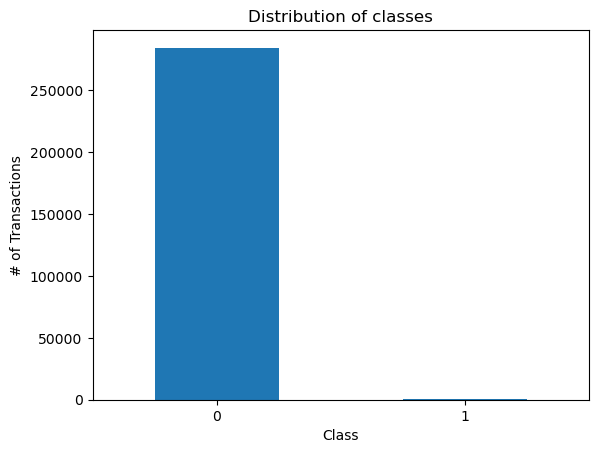

In [5]:
import matplotlib.pyplot as plt

# Distribution of transaction classes (fraud / non-fraud)
cat_dist = df["Class"].value_counts()
print("Frequencies of classes:\n", cat_dist, "\n")

# Ratio of classes
print("Ratio of classes:\n", cat_dist/len(df))

# Plot the distribution of classes
plt.xlabel("Class")
plt.ylabel("# of Transactions")
cat_dist.plot(kind="bar", title="Distribution of classes", rot=0)

Apparently, the dataset is **highly imbalanced** in terms of class distributions, as it contains only **492 fraud cases** out of **284,807 total cases**, or **0.172% of fraud cases**. This can be justified by the low frequent and covert nature of fraudulent transactions. In the later part of this lab we will see that special measures must be used to deal with this data imbalance issue.

Next, we will look into each kind of feature individually and try to reveal patterns in credit card transactions.

### Opaque Features (`V1` to `V28`)

The opaque features (`V1` to `V28`) are obtained by reducing the dimensions of raw features with PCA. The raw transaction features of credit card transactions are not provided because of privacy issues, and we have no idea about the meaning of these opaque features. In this case, one approach is to **perform PCA again on the opaque features**, reducing them to three dimensions and then **visualizing them on 2D and 3D plots** (Mathmatically this is equivalent to directly reducing raw features to three dimensions with a single PCA transformation):

Visualizing opaque features to 3D started...
Figure(2000x500)
Visualizing opaque features to 3D completed. Elapsed time: 1.17s


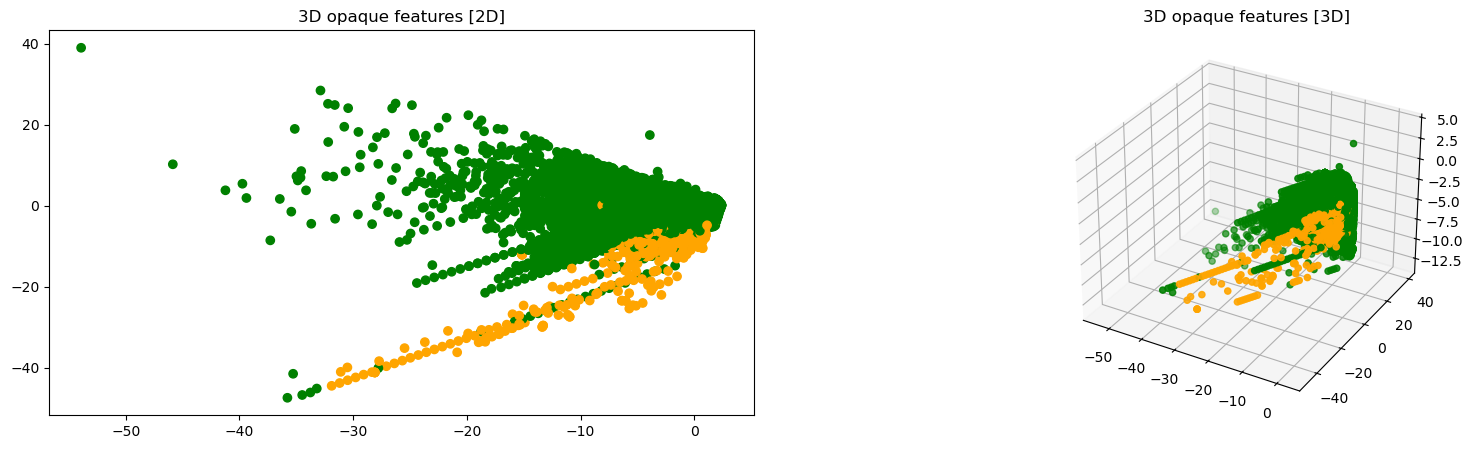

In [6]:
from sklearn.decomposition import IncrementalPCA

import lab_6_util

with lab_6_util.timeit("Visualizing opaque features to 3D"):
    # Reduce opaque features to three dimensions
    opaque_features_3d = IncrementalPCA(n_components=3).fit_transform(df.loc[:, "V1":"V28"])
    # Visualize three-dimensional opaque features
    lab_6_util.visualize_samples(opaque_features_3d, df["Class"], "3D opaque features")

The visualization plot shows that a significant portion of fraud transactions can be separated from normal transactions in the 3D space. However, to achieve better classification performance, we should incorporate additional features beyond just the opaque PCA features.

### Transaction Time

To reveal potential patterns in transaction time, we plot its distribution with `seaborn`, a library for statistical data visualization:

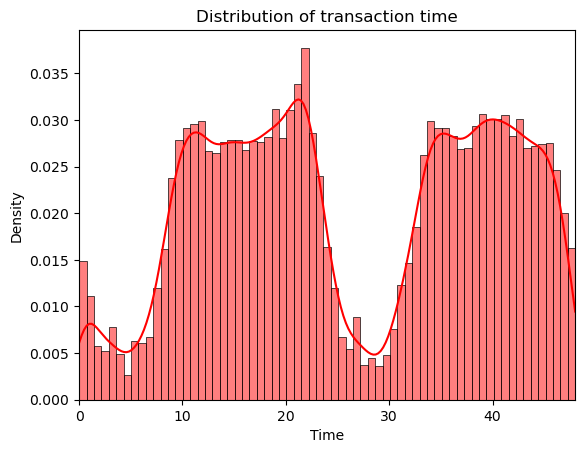

In [7]:
import seaborn as sns

# Convert transaction time from seconds to hours
time_df = df["Time"] / (60 * 60)

# Plot the distribution of transaction time
sns.histplot(time_df, color="r", kde=True, stat="density")
# Set plot title
plt.title("Distribution of transaction time")
# Set plot range
plt.xlim((time_df.min(), time_df.max()))

# Show plot
plt.show()

The plot indicates that all transactions in the dataset were collected during a **two-day period** (maximum time is 48 hours). Most transactions occur during a continuous 16-hour period in a single day, corresponding to when people are typically awake. Note that time 0 is a relative timestamp and does not correspond to any specific clock time.

Now let's examine the distribution **separately for fraud and non-fraud transactions** to identify any temporal patterns:

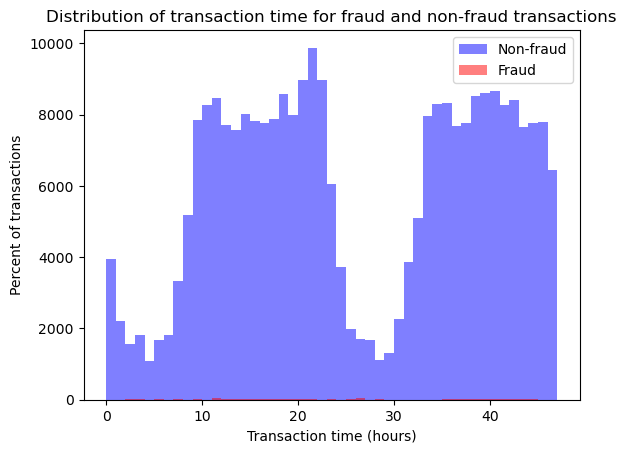

In [8]:
import numpy as np

# Fraud and non-fraud transactions
df_nonfraud = df[df["Class"]==0]
df_fraud = df[df["Class"]==1]

# X-axis of the transaction time plot
bins = np.arange(48)
# Transaction time for fraud and non-fraud transactions (in hours)
time_nonfraud = df_nonfraud["Time"]/(60*60)
time_fraud = df_fraud["Time"]/(60*60)

## [ TODO ]
# Plot transaction time distribution of fraud and non-fraud transactions SEPARATELY
# (Caution: plot the percentiles (NOT amount) for each range)
# (Hint: use `plt.hist` to plot; set fraud and non-fraud series to differnent colors and increase transparency)
plt.hist(time_nonfraud, bins=bins, color="b", alpha=0.5, label="Non-fraud")
plt.hist(time_fraud, bins=bins, color="r", alpha=0.5, label="Fraud")
plt.xlabel("Transaction time (hours)")
plt.ylabel("Percent of transactions")
plt.title("Distribution of transaction time for fraud and non-fraud transactions")
plt.legend()
plt.show()

We can observe from the plot that the proportion of non-fraud transactions decreases from hour 1 to 8 and from hour 24 to 32, while the proportion of fraud transactions increases during these periods. This suggests that **fraud transactions tend to occur more frequently during night hours**.

### Transaction Amount

Similar to the transaction time, let's also plot the distribution of transaction amount:

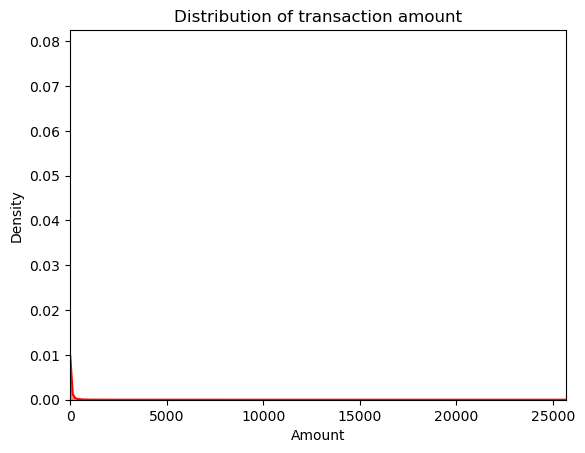

In [9]:
# Amount of all transactions
amount_df = df["Amount"]

# Plot the distribution of transaction amount
sns.histplot(amount_df, color="r", kde=True, stat="density")
# Set plot title
plt.title("Distribution of transaction amount")
# Set plot range
plt.xlim((0, amount_df.max()))

plt.show()

The distribution of transaction amount exhibits a classic **long-tail distribution**: most transactions are of low value, but there are outliers with amounts several times the mean. This characteristic can be seen in the statistics of non-fraud, fraud, and all transactions:

In [10]:
# Distribution percentiles
dist_pc = np.arange(0.1, 1, 0.1)

# Amount of non-fraud and fraud transactions
amount_nonfraud = df_nonfraud["Amount"]
amount_fraud = df_fraud["Amount"]

# Statistics of amount of non-fraud, fraud and all transactions
amount_stats = pd.DataFrame.from_dict({
    "Non-Fraud": amount_nonfraud.describe(percentiles=dist_pc),
    "Fraud": amount_fraud.describe(percentiles=dist_pc),
    "All": amount_df.describe(percentiles=dist_pc)
})

amount_stats

,Non-Fraud,Fraud,All
count,284315.000000,492.000000,284807.000000
mean,88.291022,122.211321,88.349619
std,250.105092,256.683288,250.120109
min,0.000000,0.000000,0.000000
10%,1.000000,0.760000,1.000000
20%,3.580000,1.000000,3.570000
30%,8.920000,1.000000,8.910000
40%,13.030000,2.000000,13.000000
50%,22.000000,9.250000,22.000000
60%,37.000000,39.992000,37.000000


The average fraud transaction amount is $122 USD, while non-fraud transactions average $88 USD. The distributions are similar for the bottom 60% of transactions, but **fraud transactions have higher values in the top 40%**. We can further demonstrate this pattern by plotting the distribution of high-value transactions:

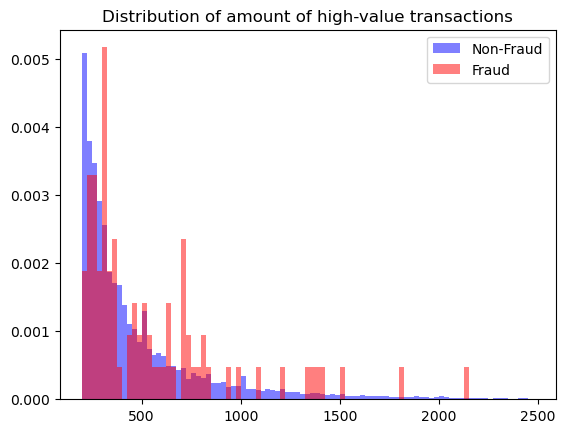

In [11]:
# X-axis of the transaction amount plot
bins = np.arange(200, 2500, 25)

# Plot high-value fraud and non-fraud transactions ($200 to $2000)
plt.hist(amount_nonfraud, bins, density=True, label="Non-Fraud", color="b", alpha=0.5)
plt.hist(amount_fraud, bins, density=True, label="Fraud", color="r", alpha=0.5)
# Set plot title
plt.title("Distribution of amount of high-value transactions")
# Show legend
plt.legend(fancybox=True)

plt.show()

We can conclude from this plot that fraud transactions tend to occur more frequently in the high-value "tail" of the transaction distribution. However, the amount feature alone would still be insufficient for accurate fraud detection.

## Feature Scaling

With the analysis of different feature types complete, we now move to the **feature scaling** step. The opaque features (`V1` to `V28`) are generated by PCA and are already normalized (measured in units of standard deviations), so they require no additional preprocessing. However, the Transaction Time and Amount features are raw values that need rescaling:

- **`StandardScaler`** could be applied to transaction time (after taking modulo 24 to get hour-of-day), but it is inappropriate for transaction amount because the amount distribution is not normal.
- **`MinMaxScaler`** is also inappropriate for transaction amount because the long-tail distribution contains many outliers that would distort the scaling.

Instead, we use **[`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)**, which performs a linear transformation using the interquartile range (IQR) as the scale factor, making it robust against outliers:

$$x_{\text{scaled}} = \frac{x - Q_{25}(x)}{Q_{75}(x) - Q_{25}(x)}$$

This formula uses the 25th percentile ($Q_{25}$) as the baseline and the difference between 75th and 25th percentiles as the scale, ensuring that outliers have minimal impact on the transformation.

In [12]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Copy original dataset
df_scaled = df.copy()

## [ TODO ]
# 1) Divide transaction time by 24 (hours in a day)
df_scaled["Time"] = df_scaled["Time"] / 24
# 2) Rescale and override transaction time column with `StandardScaler`
scaler_time = StandardScaler()
df_scaled["Time"] = scaler_time.fit_transform(df_scaled[["Time"]])
# 3) Rescale and override transaction amount column with `RobustScaler`
scaler_amount = RobustScaler()
df_scaled["Amount"] = scaler_amount.fit_transform(df_scaled[["Amount"]])
#    (Hint: refer to lab 5 and API reference for usage of feature scalers)

# Review scaling results
df_scaled[["Amount", "Time"]].head(5)

,Amount,Time
0,1.783274,-1.996583
1,-0.269825,-1.996583
2,4.983721,-1.996562
3,1.418291,-1.996562
4,0.670579,-1.996541


## Training and Evaluation

We now begin the training stage by performing a **train-test split** on the scaled dataset. Since fraud transactions are rare, we set the **test set size to 40%** to ensure sufficient fraud samples are included in the test set for reliable evaluation:

In [13]:
from sklearn.model_selection import train_test_split

# Get feature and label values from original dataset
feat_all = df_scaled.drop(["Class"], axis=1).values
y_all = df_scaled["Class"].values

# Split samples into training and test sets
feat_train, feat_test, y_train, y_test = train_test_split(
    feat_all, y_all, test_size=0.4, random_state=0
)

### Data Resampling with SMOTE

Our earlier analysis showed that the credit card fraud dataset is highly imbalanced: over 99.8% of transactions are non-fraud. To address this, we apply **data resampling** to adjust the class distribution before training. We can either **over-sample** the fraud class or **under-sample** the non-fraud class; here we use **Synthetic Minority Over-sampling TEchnique (SMOTE)**.

SMOTE synthesizes new minority samples through $k$-**nearest neighbors**:

1. Randomly select a fraud sample and find its $k$ nearest neighbors.
2. Randomly select one of these neighbors.
3. Create a synthetic sample via linear interpolation between the two selected samples.

An extension of SMOTE, called **borderline SMOTE**, enhances the original technique by first learning an **decision boundary** between the majority and minority classes and then applying SMOTE only to minor samples that are adjacent to the decision boundary. Here we will try both original and borderline SMOTE for the fraud class:

In [14]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

# SMOTE over-sampling
smote = SMOTE(random_state=0)
# Borderline SMOTE over-sampling
borderline_smote = BorderlineSMOTE(random_state=0)

### Decision Tree Classifier

A **decision tree** is a machine learning model that uses a hierarchical, tree-like structure for making predictions. To make a prediction with a decision tree:

1. Start at the root node and evaluate the associated condition
2. Follow the appropriate branch based on the condition result
3. Recursively evaluate conditions at each sub-node, moving deeper into the tree
4. Continue until reaching a leaf node, which provides the final prediction

Decision trees are versatile and work for both classification and regression problems. Below are visualizations showing a simple decision tree and its decision boundary:


Now, we will build and train three [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). The first one will be trained directly on the original samples, while the second and third one will be trained with the fraud class over-sampled using original and borderline SMOTE respectively:

In [15]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline

# 1) Train a decision tree classifier `dt` on original samples.
dt = DecisionTreeClassifier(random_state=67)
dt.fit(feat_train, y_train)

# 2) Build a ML pipeline `dt_smote` with SMOTE over-sampling and a decision tree classifier,
#    then train the whole pipeline.
dt_smote = Pipeline([
    ("smote", smote),
    ("dt", DecisionTreeClassifier(random_state=67))
])
dt_smote.fit(feat_train, y_train)
# 3) Build a ML pipeline `dt_borderline_smote` with borderline SMOTE over-sampling and
#    a decision tree classifier, then train the whole pipeline
dt_borderline_smote = Pipeline([
    ("borderline_smote", borderline_smote),
    ("dt", DecisionTreeClassifier(random_state=67))
])
dt_borderline_smote.fit(feat_train, y_train)

,steps,"[('borderline_smote', ...), ('dt', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,0
,k_neighbors,5
,m_neighbors,10
,kind,'borderline-1'
,criterion,'gini'
,splitter,'best'


## Evaluation

With the three decision tree classifiers trained, we now evaluate their performance on the test set using the **confusion matrix** and **classification report**, which includes the metrics we encountered before:

- **Precision**: Of the transactions flagged as fraud, how many actually were fraud?
- **Recall**: Of all fraud transactions in the test set, how many did we correctly identify?
- **F1-score**: The harmonic mean of precision and recall, balancing both metrics
- **Accuracy**: Overall correctness, though less useful for imbalanced datasets

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_m2m_curve(ax, xs, ys, x_metric, y_metric, title):
    """Helper function for plotting metric-to-metric curve."""
    # Plot metric-to-metric curve
    ax.plot(xs, ys)

    # Make sub-plot square
    ax.set_aspect("equal")
    # Set axes labels
    ax.set_xlabel(x_metric)
    ax.set_ylabel(y_metric)
    # Set title
    ax.set_title(title)

def evaluate_model(model, name, feat_test, y_test):
    """ Evaluate a classification model on the test set, then print and plot metrics. """
    # Make prediction from features
    pred_test = model.predict(feat_test)

    print(f"\n[ Evaluation result for {name} ]")
    # Print classification report
    print("Classification report:")
    print(classification_report(y_test, pred_test))

    # Print confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test, pred_test), "\n")

In [ ]:
# Evaluate all three trained models
evaluate_model(dt, "DT (no resampling)", feat_test, y_test)
evaluate_model(dt_smote, "DT with SMOTE", feat_test, y_test)
evaluate_model(dt_borderline_smote, "DT with borderline SMOTE", feat_test, y_test)


[ Evaluation result for DT (no resampling) ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113724
           1       0.73      0.73      0.73       199

    accuracy                           1.00    113923
   macro avg       0.87      0.87      0.87    113923
weighted avg       1.00      1.00      1.00    113923

Confusion matrix:
[[113671     53]
 [    53    146]] 


[ Evaluation result for DT with SMOTE ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    113724
           1       0.36      0.73      0.49       199

    accuracy                           1.00    113923
   macro avg       0.68      0.87      0.74    113923
weighted avg       1.00      1.00      1.00    113923

Confusion matrix:
[[113470    254]
 [    53    146]] 


[ Evaluation result for DT with borderline SMOTE ]
Classification report:
              precision    r

From the evaluation results, we observe that **over-sampling the fraud class does not improve precision, recall, or F1-score**. In fact, performance degradation is observed when original SMOTE over-sampling is applied. This suggests that simple decision trees may be limited for this task. In the next lab, we will explore ensemble learning methods and random forests to improve classification performance.

## References

1. Kaggle credit card fraud dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud
2. Seaborn API reference: https://seaborn.pydata.org/api.html
3. SMOTE over-sampling: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE
4. SMOTE for imbalance data classification: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
5. `imbalanced-learn` over-sampling API reference: https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.over_sampling
6. Receiver Operating Characteristic (ROC) curve: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
7. ROC Curves and Precision-Recall Curves for Imbalanced Classification: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/
8. Decision tree: https://en.wikipedia.org/wiki/Decision_tree
9. Decision tree learning: https://en.wikipedia.org/wiki/Decision_tree_learning
10. Decision tree algorithm with example: https://www.youtube.com/watch?v=RmajweUFKvM